In [2]:
# 02-nn-training.ipynb
# Customer Lifetime Value Prediction - Neural Network Training
# Hybrid NN with numerical features + Hugging Face embeddings
# Includes Integrated Gradients for explainability

# Download tensorflow 
!pip install tensorflow -q

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import storage, bigquery
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Configuration
PROJECT_ID = "clv-predictions-mlops"
BUCKET_NAME = "clv-prediction-data"

# Load features from GCS
!gsutil cp gs://{BUCKET_NAME}/features/clv_features.parquet /tmp/clv_features.parquet
df = pd.read_parquet('/tmp/clv_features.parquet')

print(f"Loaded {df.shape[0]} customers, {df.shape[1]} columns")
print(f"Features: {df.shape[1] - 2} (excluding customer_id and target)")

2025-12-11 16:16:58.901957: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Copying gs://clv-prediction-data/features/clv_features.parquet...
/ [1 files][  9.1 MiB/  9.1 MiB]                                                
Operation completed over 1 objects/9.1 MiB.                                      
Loaded 4266 customers, 398 columns
Features: 396 (excluding customer_id and target)


In [3]:
# Separate features and target
feature_cols = [c for c in df.columns if c not in ['customer_id', 'target_clv']]
X = df[feature_cols]
y = df['target_clv']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape[0]} customers")
print(f"Test: {X_test.shape[0]} customers")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Log transform target (handles wide range $0 - $287K)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

print(f"\nTarget stats:")
print(f"  Original range: ${y_train.min():.0f} - ${y_train.max():.0f}")
print(f"  Log range: {y_train_log.min():.2f} - {y_train_log.max():.2f}")

Train: 3412 customers
Test: 854 customers

Target stats:
  Original range: $0 - $287492
  Log range: 0.00 - 12.57


In [4]:
# Build hybrid neural network
model = keras.Sequential([
    layers.Input(shape=(396,)),
    
    # Hidden layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(32, activation='relu'),
    
    # Output layer (predicting log CLV)
    layers.Dense(1)
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print(model.summary())

2025-12-11 16:21:22.467763: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       101,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,433 (572.00 KB)

 Trainable params: 145,665 (569.00 KB)

 Non-trainable params: 768 (3.00 KB)

None


In [5]:
# Train the model
history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ],
    verbose=1
)

print(f"\nTraining complete - {len(history.history['loss'])} epochs")

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 14.0674 - mae: 3.1313 - val_loss: 11.7877 - val_mae: 3.1679 - learning_rate: 0.0010
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0627 - mae: 2.6196 - val_loss: 9.7380 - val_mae: 2.7955 - learning_rate: 0.0010
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.0496 - mae: 2.4280 - val_loss: 9.4944 - val_mae: 2.7147 - learning_rate: 0.0010
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4571 - mae: 2.3196 - val_loss: 8.8249 - val_mae: 2.5083 - learning_rate: 0.0010
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1871 - mae: 2.2488 - val_loss: 8.9097 - val_mae: 2.6195 - learning_rate: 0.0010
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.6825 - mae: 2.1311 - val_loss: 9.0675 - val_mae: 2.5070 - learning_rate: 0.0010
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4492 - mae: 2.0926 - val_loss: 9.0382 - val_mae: 2.4639 - learning_rate: 0.0010
Epoch 8/100

In [6]:
# Evaluate on test set
y_pred_log = model.predict(X_test_scaled).flatten()

# Convert back from log scale to dollars
y_pred = np.expm1(y_pred_log)  # Inverse of log1p
y_actual = y_test.values

# Calculate metrics
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("="*50)
print("TEST SET RESULTS")
print("="*50)
print(f"MAE:  ${mae:,.0f}")
print(f"R²:   {r2:.3f}")
print(f"\nInterpretation: Predictions are off by ${mae:,.0f} on average")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
TEST SET RESULTS
MAE:  $36,253
R²:   -7169.513

Interpretation: Predictions are off by $36,253 on average


In [7]:
# Debug: check predictions vs actuals
print("Predictions stats:")
print(f"  Min: ${y_pred.min():,.0f}")
print(f"  Max: ${y_pred.max():,.0f}")
print(f"  Mean: ${y_pred.mean():,.0f}")

print("\nActuals stats:")
print(f"  Min: ${y_actual.min():,.0f}")
print(f"  Max: ${y_actual.max():,.0f}")
print(f"  Mean: ${y_actual.mean():,.0f}")

# Check for NaN or infinity
print(f"\nNaN in predictions: {np.isnan(y_pred).sum()}")
print(f"Inf in predictions: {np.isinf(y_pred).sum()}")

Predictions stats:
  Min: $0
  Max: $27,281,760
  Mean: $36,050

Actuals stats:
  Min: $0
  Max: $280,206
  Mean: $1,900

NaN in predictions: 0
Inf in predictions: 0


In [8]:
# Retrain without log transform
model2 = keras.Sequential([
    layers.Input(shape=(396,)),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

# Train on raw dollar values (not log)
history2 = model2.fit(
    X_train_scaled, y_train,  # Raw dollars, not log
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True),
    ],
    verbose=1
)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 85163976.0000 - mae: 1761.0625 - val_loss: 17964852.0000 - val_mae: 1441.7504
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 84221904.0000 - mae: 1702.7113 - val_loss: 16718915.0000 - val_mae: 1323.0776
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 81557992.0000 - mae: 1643.1217 - val_loss: 15146129.0000 - val_mae: 1361.0118
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 78887920.0000 - mae: 1788.7404 - val_loss: 14774620.0000 - val_mae: 1560.4680
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 77293224.0000 - mae: 1911.1418 - val_loss: 14589931.0000 - val_mae: 1629.7545
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 75372392.0000 - mae: 2019.2292 - val_loss: 14519245.0000 - val_mae: 1698.8967
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 74555176.0000 - mae: 2038.2900 - val_loss: 14132938.0000 - val_mae: 1660.2405
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s

In [9]:
# Evaluate model2
y_pred2 = model2.predict(X_test_scaled).flatten()
y_pred2 = np.clip(y_pred2, 0, None)  # CLV can't be negative

mae2 = mean_absolute_error(y_actual, y_pred2)
r2_2 = r2_score(y_actual, y_pred2)

print("="*50)
print("TEST SET RESULTS (Model 2 - No Log Transform)")
print("="*50)
print(f"MAE:  ${mae2:,.0f}")
print(f"R²:   {r2_2:.3f}")

print(f"\nPrediction range: ${y_pred2.min():,.0f} - ${y_pred2.max():,.0f}")
print(f"Actual range:     ${y_actual.min():,.0f} - ${y_actual.max():,.0f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
TEST SET RESULTS (Model 2 - No Log Transform)
MAE:  $1,987
R²:   0.104

Prediction range: $11 - $12,948
Actual range:     $0 - $280,206


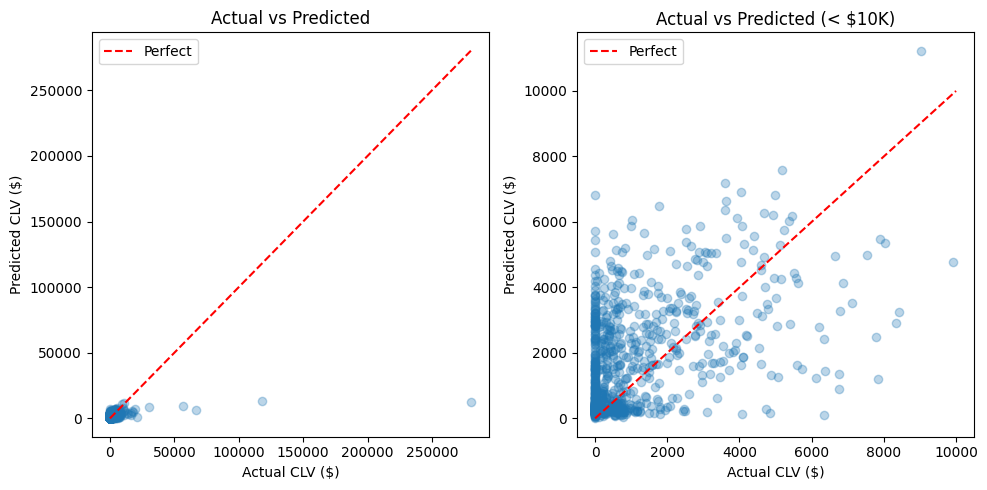

Saved: clv_predictions.png


In [10]:
# Plot actual vs predicted
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_actual, y_pred2, alpha=0.3)
plt.plot([0, y_actual.max()], [0, y_actual.max()], 'r--', label='Perfect')
plt.xlabel('Actual CLV ($)')
plt.ylabel('Predicted CLV ($)')
plt.title('Actual vs Predicted')
plt.legend()

plt.subplot(1, 2, 2)
# Zoom in on bulk of data (exclude extreme outliers)
mask = y_actual < 10000
plt.scatter(y_actual[mask], y_pred2[mask], alpha=0.3)
plt.plot([0, 10000], [0, 10000], 'r--', label='Perfect')
plt.xlabel('Actual CLV ($)')
plt.ylabel('Predicted CLV ($)')
plt.title('Actual vs Predicted (< $10K)')
plt.legend()

plt.tight_layout()
plt.savefig('clv_predictions.png', dpi=150)
plt.show()

print("Saved: clv_predictions.png")

In [11]:
# Install Integrated Gradients library
!pip install alibi -q

In [13]:
# Integrated Gradients - explains which features drive predictions
from alibi.explainers import IntegratedGradients

# Create explainer
ig = IntegratedGradients(model2, n_steps=50)

# Explain a sample prediction (high-value customer)
high_value_idx = np.argmax(y_pred2)
sample = X_test_scaled[high_value_idx:high_value_idx+1]

explanation = ig.explain(sample)
attributions = explanation.attributions[0][0]  # Feature importances

print(f"Customer prediction: ${y_pred2[high_value_idx]:,.0f}")
print(f"Customer actual: ${y_actual[high_value_idx]:,.0f}")

It looks like you are passing a model with a scalar output and target is set to `None`.If your model is a regression model this will produce correct attributions. If your model is a classification model, targets for each datapoint must be defined. Not defining the target may lead to incorrect values for the attributions.Targets can be either the true classes or the classes predicted by the model.


Customer prediction: $12,948
Customer actual: $117,702


2025-12-11 16:31:35.684129: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


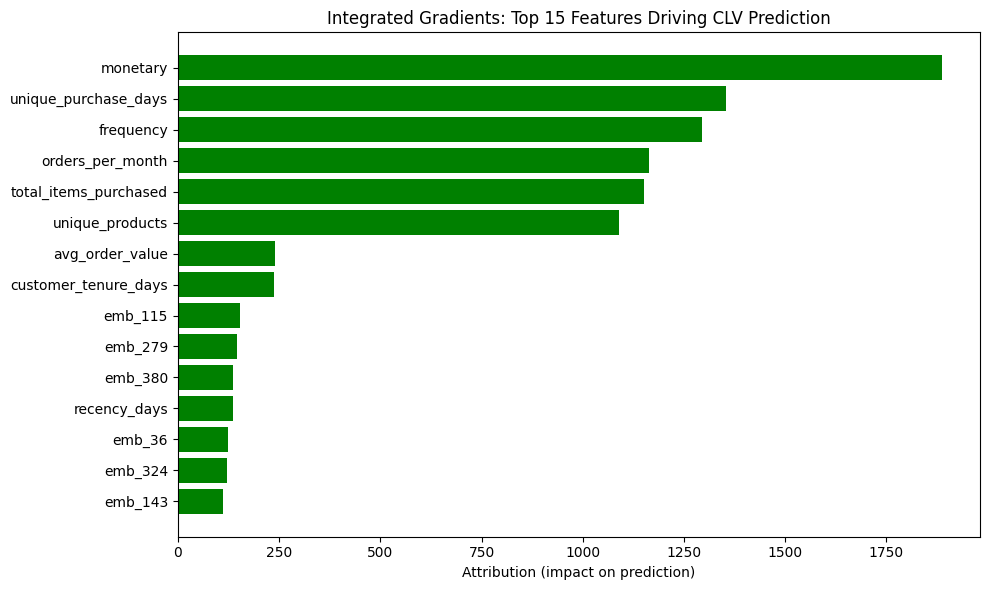


Green = increases predicted CLV
Red = decreases predicted CLV

Saved: integrated_gradients.png


In [14]:
# Get feature names
feature_names = list(X.columns)

# Get top 15 most important features (by absolute attribution)
top_idx = np.argsort(np.abs(attributions))[-15:]
top_features = [feature_names[i] for i in top_idx]
top_attrs = attributions[top_idx]

# Plot
plt.figure(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in top_attrs]
plt.barh(top_features, top_attrs, color=colors)
plt.xlabel('Attribution (impact on prediction)')
plt.title('Integrated Gradients: Top 15 Features Driving CLV Prediction')
plt.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('integrated_gradients.png', dpi=150)
plt.show()

print("\nGreen = increases predicted CLV")
print("Red = decreases predicted CLV")
print("\nSaved: integrated_gradients.png")

In [18]:
# Save both formats
model2.export('clv_model')  # SavedModel directory for deployment
model2.save('clv_model.keras')  # Single file for backup

import joblib
joblib.dump(scaler, 'clv_scaler.pkl')

# Upload to GCS
!gsutil -m cp -r clv_model gs://{BUCKET_NAME}/models/
!gsutil cp clv_model.keras gs://{BUCKET_NAME}/models/
!gsutil cp clv_scaler.pkl gs://{BUCKET_NAME}/models/

print("\nNotebook 02 Complete!")
print("="*50)
print(f"Baseline Model Results:")
print(f"  MAE:  ${mae2:,.0f}")
print(f"  R²:   {r2_2:.3f}")
print(f"\nArtifacts saved to GCS:")
print(f"  gs://{BUCKET_NAME}/models/clv_model/ (SavedModel)")
print(f"  gs://{BUCKET_NAME}/models/clv_model.keras")
print(f"  gs://{BUCKET_NAME}/models/clv_scaler.pkl")
print(f"\nNext: 03-hyperparameter-tuning.ipynb (Vertex AI Vizier)")

INFO:tensorflow:Assets written to: clv_model/assets


INFO:tensorflow:Assets written to: clv_model/assets


Saved artifact at 'clv_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 396), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140272781469728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140272782291568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140272782287520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140271686256416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140271686269616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140271320334576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140271320348480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140271320338976: TensorSpec(shape=(), dtype=tf.resource, name=None)
Copying file://clv_model/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://clv_model/fingerprint.pb [Content-Type=application/octet-stream]...
Co